# Fitting photometric data

This example will take you through the basics of fitting photometric data. You can find further information on the [fitting observational data](http://bagpipes.readthedocs.io/en/latest/fitting_galaxies.html) page of the documentation.

## Setting up

First we're going to need to load up the observational data as a galaxy object, as demonstrated in Example 2:

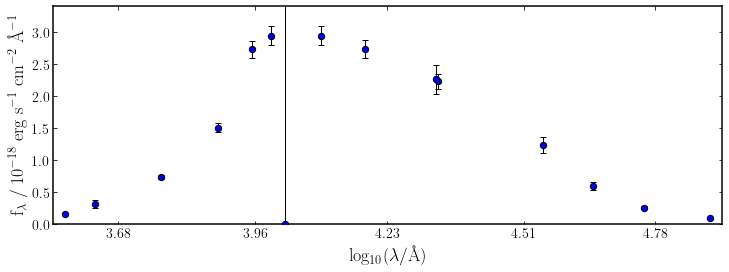

In [1]:
import numpy as np 
import bagpipes as pipes
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from astropy.io import fits


def load_goodss(ID):
#     """ Load UltraVISTA photometry from catalogue. """

#     # load up the relevant columns from the catalogue.
#     cat = np.loadtxt("hlsp_candels_hst_wfc3_goodss-tot-multiband_f160w_v1-1photom_cat.txt",
#                      usecols=(10, 13, 16, 19, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55,
#                               11, 14, 17, 20, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56))
    
#     # Find the correct row for the object we want.
#     row = int(ID) - 1

#     # Extract the object we want from the catalogue.
#     fluxes = cat[row, :15]
#     fluxerrs = cat[row, 15:]

#     # Turn these into a 2D array.
#     photometry = np.c_[fluxes, fluxerrs]

#     # blow up the errors associated with any missing fluxes.
#     for i in range(len(photometry)):
#         if (photometry[i, 0] == 0.) or (photometry[i, 1] <= 0):
#             photometry[i,:] = [0., 9.9*10**99.]
            
#     # Enforce a maximum SNR of 20, or 10 in the IRAC channels.
#     for i in range(len(photometry)):
#         if i < 10:
#             max_snr = 20.
            
#         else:
#             max_snr = 10.
        
#         if photometry[i, 0]/photometry[i, 1] > max_snr:
#             photometry[i, 1] = photometry[i, 0]/max_snr

    return np.array([[6.987040e-02, 7.049980e-03],
                     [1.923840e-01, 4.059220e-02],
                     [8.308090e-01, 4.154045e-02],
                     [2.950840e+00, 1.475420e-01],
                     [7.377370e+00, 3.688685e-01],
                     [9.502210e+00, 4.751105e-01],
                     [0.000000e+00, 9.900000e+99],
                     [1.516060e+01, 7.580300e-01],
                     [2.142950e+01, 1.071475e+00],
                     [3.460530e+01, 1.730265e+00],
                     [3.460900e+01, 3.460900e+00],
                     [5.131500e+01, 5.131500e+00],
                     [3.950320e+01, 3.950320e+00],
                     [2.687740e+01, 2.687740e+00],
                     [1.799710e+01, 1.799710e+00]])

goodss_filt_list = np.loadtxt("filters/goodss_filt_list.txt", dtype="str")

galaxy = pipes.galaxy("17433", load_goodss, spectrum_exists=False, filt_list=goodss_filt_list)

fig = galaxy.plot()

## The fit instructions dictionary

Next we need to define the model we want to fit to the data. We do this by creating a [fit instructions dictionary](https://bagpipes.readthedocs.io/en/latest/fit_instructions.html). In many ways this is similar to the model components dictionary (see Example 1). However there are a few extra options for defining the parameters we wish to fit and the priors we wish to impose.

In [3]:
exp = {}                                  # Tau-model star-formation history component
exp["age"] = (0.1, 15.)                   # Vary age between 100 Myr and 15 Gyr. In practice 
                                          # the code automatically limits this to the age of
                                          # the Universe at the observed redshift.

exp["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
exp["massformed"] = (1., 15.)             # vary log_10(M*/M_solar) between 1 and 15
exp["metallicity"] = (0., 2.5)            # vary Z between 0 and 2.5 Z_oldsolar

dust = {}                                 # Dust component
dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
dust["Av"] = (0., 2.)                     # Vary Av between 0 and 2 magnitudes

fit_instructions = {}                     # The fit instructions dictionary
fit_instructions["redshift"] = (0., 10.)  # Vary observed redshift from 0 to 10
fit_instructions["exponential"] = exp   
fit_instructions["dust"] = dust

Now we can pass the galaxy object and the fit_instructions dictionary into a fit object and run the MultiNest sampler to fit the data. 

In [4]:
fit = pipes.fit(galaxy, fit_instructions)

fit.fit(verbose=False)


Bagpipes: fitting object 17433

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    6
 *****************************************************

Completed in 150.6 seconds.
 ln(ev)=   389.73302726618959      +/-  0.22224624036672777     
 Total Likelihood Evaluations:        83122
 Sampling finished. Exiting MultiNest

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.227      0.385      0.559
exponential:age                2.395      2.623      3.082
exponential:massformed        11.150     11.197     11.251
exponential:metallicity        0.643      1.018      1.506
exponential:tau                0.310      0.339      0.406
redshift              

## Accessing posterior information

Samples from the posterior distribution for the fitted parameters are saved into the fit.posterior.samples dictionary. Some basic derived quantities are also calculated by default:

In [5]:
list(fit.posterior.samples)

['dust:Av',
 'exponential:age',
 'exponential:massformed',
 'exponential:metallicity',
 'exponential:tau',
 'redshift',
 'stellar_mass',
 'formed_mass',
 'sfr',
 'ssfr',
 'nsfr',
 'mass_weighted_age',
 'tform',
 'tquench',
 'sfh']

The first dimension of all of these arrays runs over the samples in the posterior.

If we want to know the posterior median living stellar mass we can write:

In [7]:
print(np.median(fit.posterior.samples["stellar_mass"]))

10.928059979654375


Or the posterior median specific star-formation rate:

In [8]:
print(np.median(np.log10(fit.posterior.samples["sfr"]) - fit.posterior.samples["stellar_mass"]))

-11.561869809892373


Or the confidence interval on the mass-weighted age:

In [9]:
print(np.percentile(fit.posterior.samples["mass_weighted_age"], (16, 84)))

[2.08812768 2.67746958]


## Further posterior quantities

By default, samples for posterior quantities relating to the spectrum (e.g. posterior predictions for photometry, spectroscopy, rest-frame UVJ magnitudes etc) are not generated. These can be calculated using:

In [10]:
fit.posterior.get_advanced_quantities()
list(fit.posterior.samples)

['dust:Av',
 'exponential:age',
 'exponential:massformed',
 'exponential:metallicity',
 'exponential:tau',
 'redshift',
 'stellar_mass',
 'formed_mass',
 'sfr',
 'ssfr',
 'nsfr',
 'mass_weighted_age',
 'tform',
 'tquench',
 'sfh',
 'photometry',
 'spectrum_full',
 'uvj',
 'chisq_phot',
 'dust_curve']

Saving and loading posteriors
-----------------------------------

When a fit is finished, basic outputs needed to reconstruct the results of a fit are saved as a hdf5 file in the "pipes/posterior" directory. If this posterior file already exists when you create the fit object it'll automatically be loaded, and you won't be able to run the fit method again.

In [11]:
fit = pipes.fit(galaxy, fit_instructions)

fit.fit(verbose=False)


Results loaded from pipes/posterior/./17433.h5

Fitting not performed as results have already been loaded from pipes/posterior/./17433.h5. To start over delete this file or change run.



If you want to start over just delete the posterior file. Alternatively, when you create your fit object, set the keyword argument "run" to some string, and this will start a brand new fit, the outputs of which will be saved in subfolders within pipes/posterior and pipes/plots with the same name as your run.

## Diagnostic plots

Bagpipes allows the creation of several standard diagnostic plots to visualise fitting results.

By default all of the plots one creates showing the fitting results are saved in the "pipes/plots" directory, here we will show them instead.


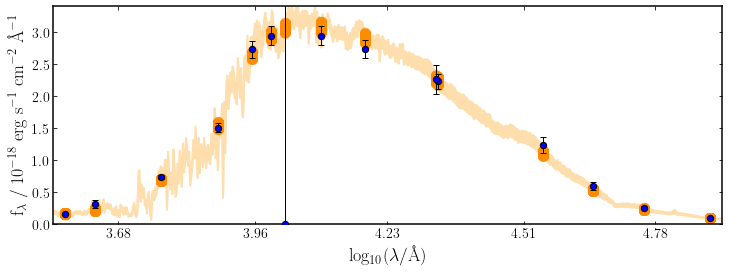

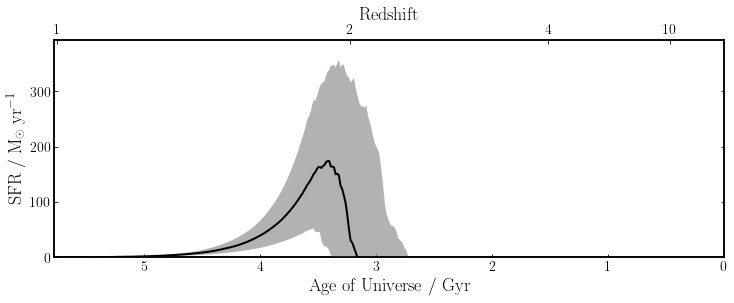

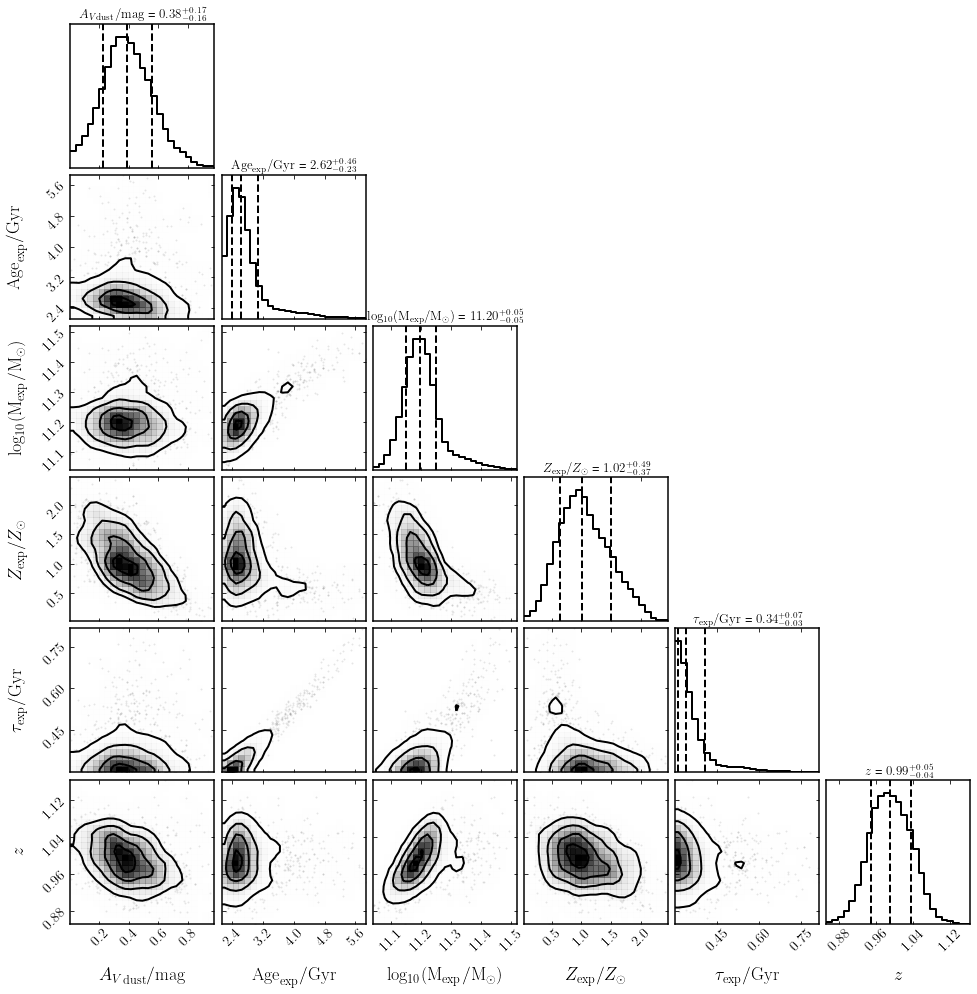

In [12]:
fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)
fig = fit.plot_corner(save=False, show=True)

The plotting interface is designed to be flexible enough that you can generate custom plots of things you want to see without having to start from scratch. The automatic latex axis labeller is coming on quite nicely as well!

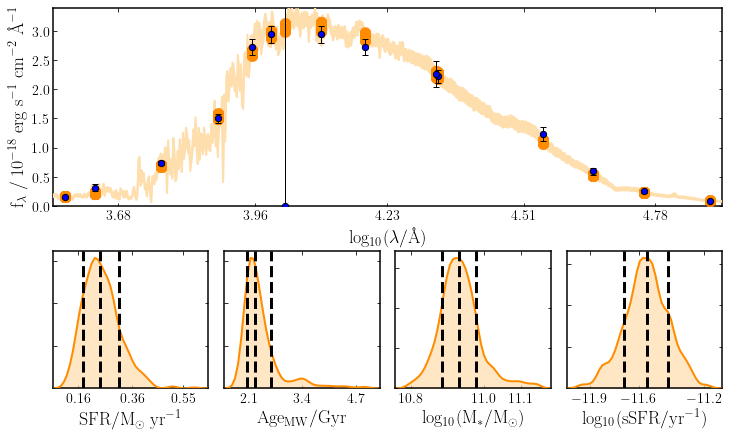

In [13]:
plt.close()

fig = plt.figure(figsize=(12, 7))
gs = mpl.gridspec.GridSpec(7, 4, hspace=3., wspace=0.1)

ax1 = plt.subplot(gs[:4, :])

pipes.plotting.add_observed_photometry(fit.galaxy, ax1, zorder=10)
pipes.plotting.add_photometry_posterior(fit, ax1)

labels = ["sfr", "mass_weighted_age", "stellar_mass", "ssfr"]

post_quantities = dict(zip(labels, [fit.posterior.samples[l] for l in labels]))

axes = []
for i in range(4):
    axes.append(plt.subplot(gs[4:, i]))
    pipes.plotting.hist1d(post_quantities[labels[i]], axes[-1], smooth=True, label=labels[i])

plt.show()

Move on to the next example to see how to fit more complicated models, including imposing priors on your fitting parameters.

## MPI Parallelisation

Bagpipes supports MPI parallelisation of fitting with MultiNest. You will need to install both MPI and the mpi4py python package. All you then need to do is run mpirun/mpiexec -n nproc python pythoncode.py and MultiNest will automatically use multiple cores for likelihood calls.